In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Подготовка данных

Так как изображения имеют разные размеры, для обучения модели используется letterbox-преобразование, которое масштабирует картинку с сохранением пропорций и добавляет отступы до фиксированного размера. При этом ключевые точки пересчитываются с учётом масштаба и паддинга, чтобы сохранить их корректное положение.

In [3]:
class LicensePlateKeypointsDataset(Dataset):
    def __init__(self, paths_file, input_size=(416,416), transform=None):
        with open(paths_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
        self.input_size = input_size
        self.transform = transform

    def letterbox(self, img):
        h, w = img.shape[:2]
        new_w, new_h = self.input_size
        scale = min(new_w / w, new_h / h)
        resized_w, resized_h = int(w * scale), int(h * scale)
        img_resized = cv2.resize(img, (resized_w, resized_h))
        dw = new_w - resized_w
        dh = new_h - resized_h
        top, bottom = dh//2, dh - dh//2
        left, right = dw//2, dw - dw//2
        img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right,
                                        cv2.BORDER_CONSTANT, value=(114,114,114))
        return img_padded, scale, left, top, (w, h)

    def load_labels(self, img_path):
        label_path = img_path.replace('/images/', '/labels/').replace('.png', '.txt')
        points = np.loadtxt(label_path)[5:]  # тут ключевые точки из разметки yolo
        return points

    def transform_keypoints(self, keypoints, scale, pad_x, pad_y, orig_size):
        orig_w, orig_h = orig_size
        keypoints = keypoints.reshape(-1,2).copy()
        
        keypoints[:,0] = keypoints[:,0] * orig_w * scale + pad_x
        keypoints[:,1] = keypoints[:,1] * orig_h * scale + pad_y
        
        keypoints[:,0] /= self.input_size[0]
        keypoints[:,1] /= self.input_size[1]
        
        return keypoints.flatten()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        keypoints = self.load_labels(img_path)
        img, scale, pad_x, pad_y, orig_size = self.letterbox(img)
        keypoints_transformed = self.transform_keypoints(keypoints, scale, pad_x, pad_y, orig_size)
        img = torch.from_numpy(img).unsqueeze(0).float() / 255.0  # C,H,W
        return img, torch.from_numpy(keypoints_transformed).float()

In [6]:
train_dataset = LicensePlateKeypointsDataset('../data/train.txt')
val_dataset = LicensePlateKeypointsDataset('../data/val.txt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [4]:
def draw_dataset_element(dataset, idx=0, point_color=(255,0,0), point_size=3):
    img_tensor, keypoints = dataset[idx]
    img_np = img_tensor.squeeze(0).numpy()
    img_np = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
    h, w = img_np.shape[:2]
    
    keypoints = keypoints.numpy()
    print(keypoints)
    for i in range(0, len(keypoints), 2):
        x = int(keypoints[i] * w)
        y = int(keypoints[i+1] * h)
        cv2.circle(img_np, (x, y), point_size, point_color, -1)

    img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
def draw_model_pred(img, pred, point_color=(255,0,0), point_size=3):
    img_np = img.squeeze(0).numpy()
    img_np = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
    h, w = img_np.shape[:2]
    
    pred = pred.numpy()[0]
    print(pred)
    for i in range(0, len(pred), 2):
        x = int(pred[i] * w)
        y = int(pred[i+1] * h)
        cv2.circle(img_np, (x, y), point_size, point_color, -1)

    img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

[0.199753   0.24124359 0.912938   0.3305905  0.815358   0.77669483
 0.095349   0.6841431 ]


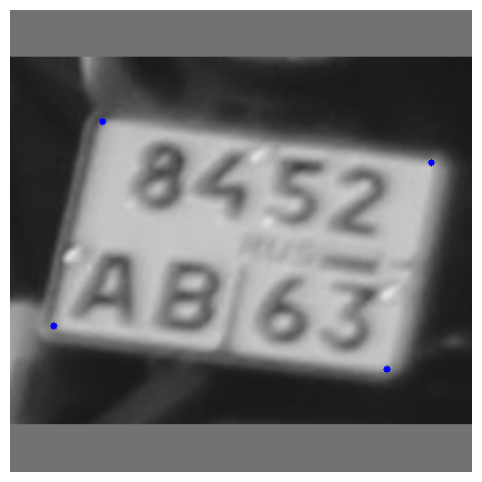

In [ ]:
draw_dataset_element(train_dataset, 8000)

## Реализация архитектуры и обучение модели

В качестве энкодера решил попробовать ResNet18. Реализовал модель через Lightning, удобная надстройка над чистым торчом.

In [5]:
class LicensePlateKeypointsModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-5):
        super().__init__()
        self.learning_rate = learning_rate
        resnet = models.resnet18()
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.encoder[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 8) # 8 координат точек
        )

        self.loss_fn = nn.SmoothL1Loss()
    
    def forward(self, x):
        features = self.encoder(x)
        features = features.flatten(1)
        out = self.decoder(features)
        return torch.sigmoid(out)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y.float())
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y.float())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [61]:
logger = TensorBoardLogger("../logs", name="lpl")

checkpoint = ModelCheckpoint(
    monitor="val_loss",
    dirpath="../checkpoints",
    filename="lpl__2_layers_decoder__{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=100000,
    devices=[0],
    accelerator="gpu",
    logger=logger,
    callbacks=[checkpoint],
    log_every_n_steps=1,
    enable_progress_bar=False
)

lpl_model = LicensePlateKeypointsModel(learning_rate=1e-3)
trainer.fit(lpl_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Sequential   | 11.2 M | train
1 | decoder | Sequential   | 133 K  | train
2 | loss_fn | SmoothL1Loss | 0      | train
-------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.214    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mo

SystemExit: 1

c:\Users\t0sss\miniconda3\envs\lpl\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
test_dataset = LicensePlateKeypointsDataset('../data/test.txt')
test_dataset[0]

(tensor([[[0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
          [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
          [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
          ...,
          [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
          [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
          [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471]]]),
 tensor([0.0613, 0.1778, 0.9118, 0.2445, 0.9183, 0.8348, 0.0903, 0.7380]))

[0.0770212  0.18670121 0.92414224 0.23986706 0.92030454 0.8369372
 0.08245872 0.7444324 ]


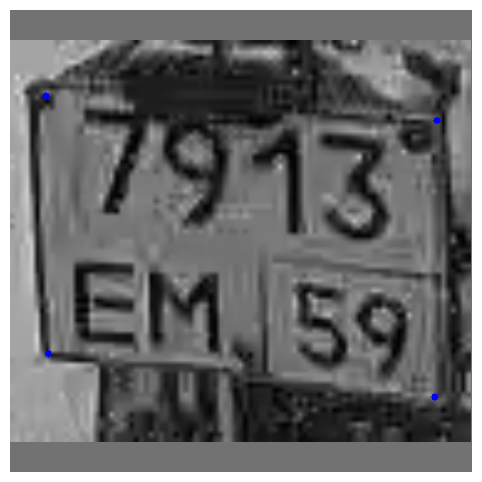

[0.08594493 0.27735326 0.92748785 0.2477574  0.92654145 0.7117486
 0.10806388 0.73457754]


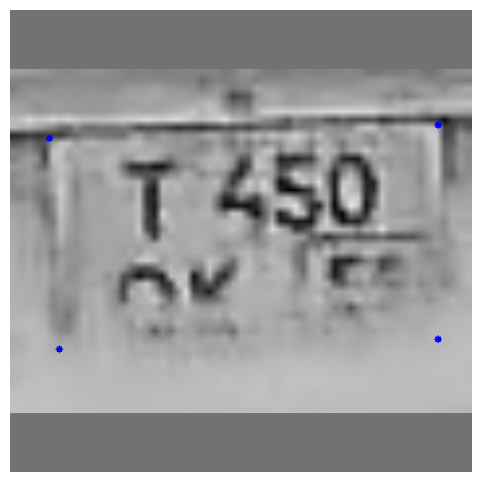

[0.17814152 0.41921434 0.932077   0.44731677 0.9318846  0.5852519
 0.17238612 0.5631385 ]


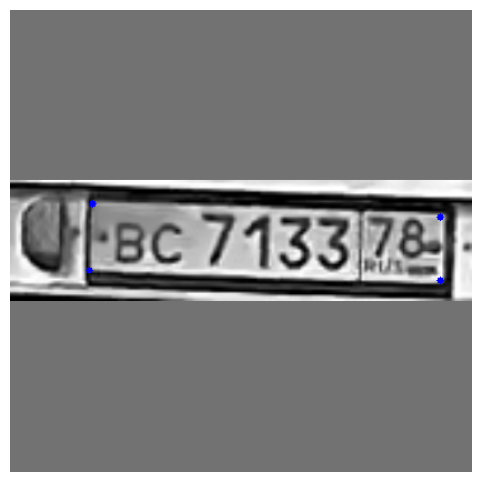

[0.08836219 0.40461564 0.9380112  0.4356442  0.93884814 0.60339737
 0.08292707 0.5718528 ]


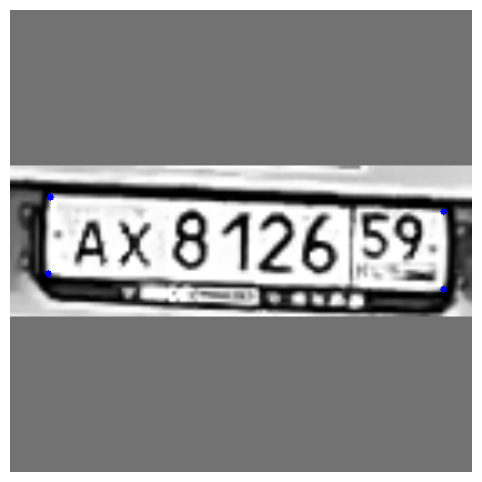

[0.04698839 0.40711248 0.96675205 0.4289001  0.96344423 0.597883
 0.04900124 0.5819546 ]


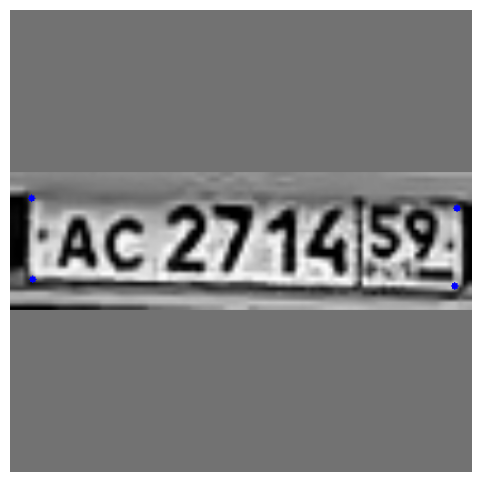

[0.08485452 0.39684057 0.8404692  0.42847472 0.83315223 0.5752039
 0.08067844 0.5451801 ]


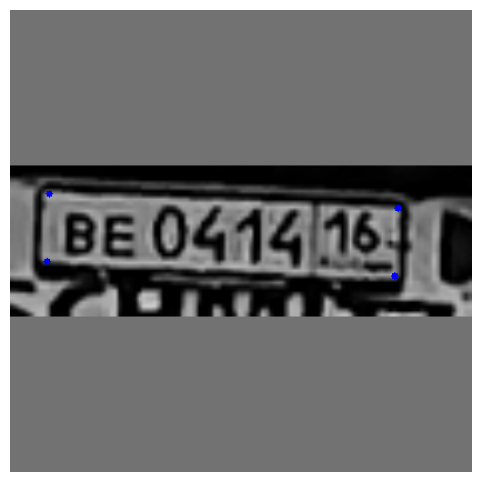

[0.12874834 0.21324092 0.92629343 0.19401594 0.90254754 0.8081237
 0.09917925 0.8132061 ]


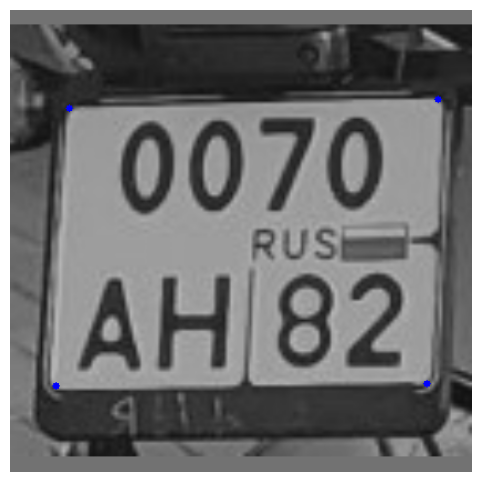

[0.07309504 0.3485159  0.9503095  0.44793153 0.9620514  0.6522221
 0.07733868 0.5449429 ]


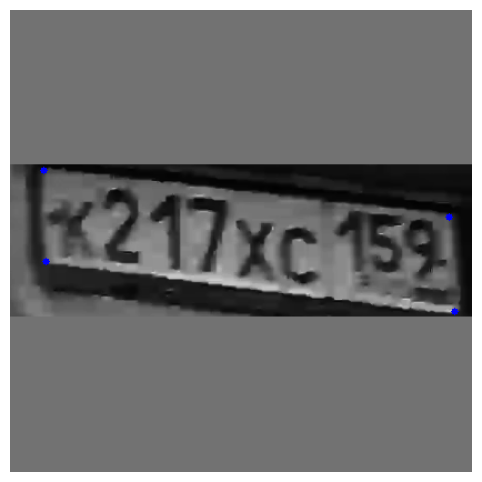

[0.10257285 0.3906889  0.93664235 0.47699735 0.9307527  0.6445491
 0.1057651  0.5492176 ]


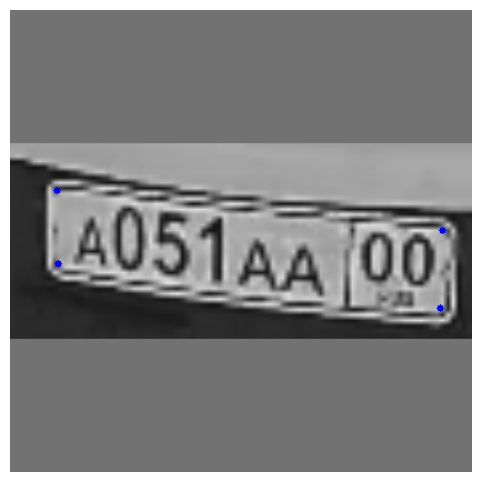

[0.14315198 0.43081725 0.9483416  0.4529282  0.94049984 0.62747043
 0.14190163 0.6004932 ]


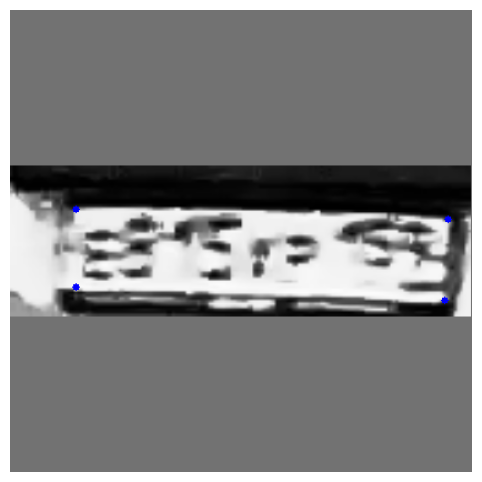

[0.15908529 0.45882624 0.89902884 0.47269607 0.90223944 0.63360757
 0.15537432 0.62181365]


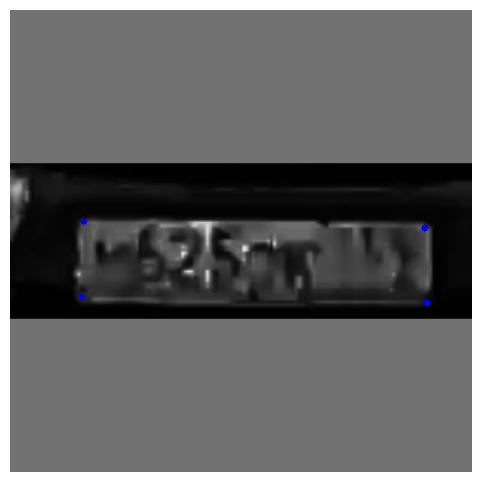

[0.10529763 0.1977239  0.89496386 0.19258097 0.912399   0.79338074
 0.11914423 0.8135893 ]


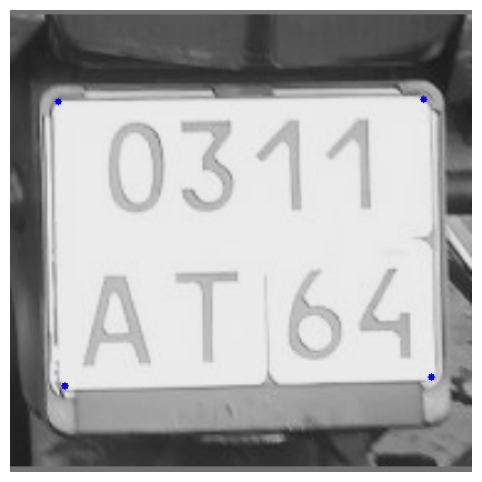

[0.08596381 0.43072248 0.9120361  0.43825412 0.9131942  0.5821285
 0.07826182 0.5703969 ]


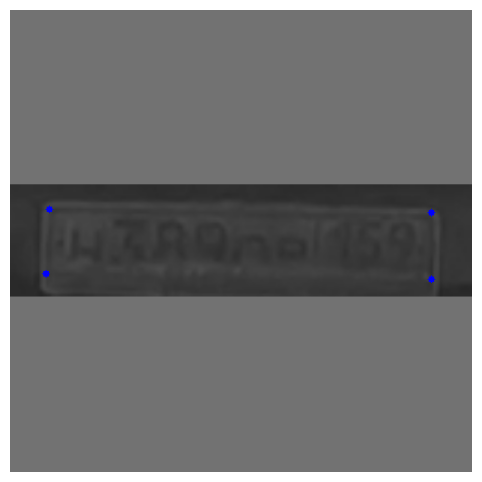

[0.1606557  0.37497976 0.66872305 0.19132663 0.8400011  0.63081044
 0.33802298 0.82921064]


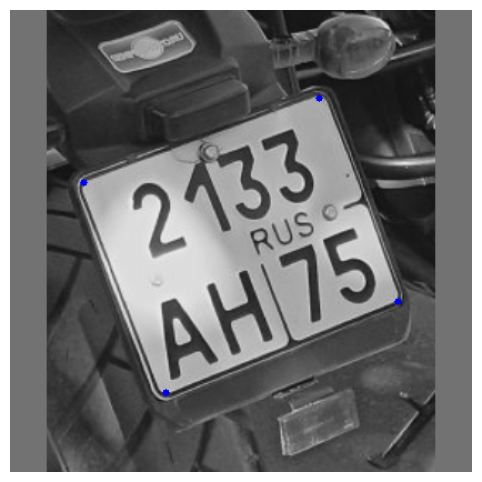

In [69]:
lpl_mpdel = LicensePlateKeypointsModel()
ckpt = torch.load('../checkpoints/lpl__2_layers_decoder__epoch=99-val_loss=0.00.ckpt')
lpl_mpdel.load_state_dict(ckpt["state_dict"])
lpl_mpdel.eval()
lpl_mpdel.to("cpu")
with torch.no_grad():
    for img, lbl in test_dataset:
        pred = lpl_mpdel(img.unsqueeze(0))
        draw_model_pred(img, pred)

## Экспорт модели в ONNX

In [5]:
lpl_mpdel = LicensePlateKeypointsModel()
ckpt = torch.load('../checkpoints/lpl__2_layers_decoder__epoch=99-val_loss=0.00.ckpt')
lpl_mpdel.load_state_dict(ckpt["state_dict"])
lpl_mpdel.eval()
lpl_mpdel.to("cpu")

LicensePlateKeypointsModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [11]:
example_input =  train_dataset[0][0].unsqueeze(0)

torch.onnx.export(
    lpl_mpdel, 
    example_input, 
    "lpl_resnet.onnx", 
    export_params=True,  
    opset_version=16,  
    input_names=["input"],  
    output_names=["output"]
)

C:\Users\t0sss\AppData\Local\Temp\ipykernel_14016\248594816.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


# Квантизация

In [15]:
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType, QuantFormat, quantize_static, CalibrationDataReader

## Динамическая квантизация

In [ ]:
quantize_dynamic(
    "../models/lpl_resnet.onnx",
    "../models/lpl_resnet_dynamic_quantized.onnx",
    weight_type=QuantType.QUInt8
)

## Статическая квантизация

In [16]:
class DataReader(CalibrationDataReader):
    def __init__(self, calibration_dataset):
        self.dataset = calibration_dataset
        self.iterator = iter(calibration_dataset)
    
    def get_next(self):
        try:
            batch = next(self.iterator)
            return {'input': batch[0].unsqueeze(0).numpy()}  # Зависит от структуры ваших данных
        except StopIteration:
            return None


quantize_static(
    "../models/lpl_resnet.onnx",
    "../models/lpl_resnet_static_quantized.onnx",
    calibration_data_reader=DataReader(test_dataset),
    quant_format=QuantFormat.QOperator,
    activation_type=QuantType.QUInt8,
    weight_type=QuantType.QInt8
)

# Оценка качества модели

In [11]:
import time
from sklearn.metrics import mean_absolute_error

## До квантизации

In [12]:
session = ort.InferenceSession("../models/lpl_resnet.onnx")
input_name = session.get_inputs()[0].name
maes = []
times = []
for x,y in test_dataset:
    x = x.numpy()
    x = np.expand_dims(x, axis=0)
    start = time.time()
    outputs = session.run(None, {input_name: x})
    end = time.time()
    maes.append(mean_absolute_error(y.numpy(), outputs[0][0]))
    times.append(end-start)

print(f"Среднее значение MAE: {np.mean(maes):5f}")
print(f"Среднее время инференса модели: {np.mean(times)*1000:.2f} мс")

Среднее значение MAE: 0.003695
Среднее время инференса модели: 29.71 мс


## После динамической квантизации

In [13]:
session = ort.InferenceSession("../models/lpl_resnet_dynamic_quantized.onnx")
input_name = session.get_inputs()[0].name
maes = []
times = []
for x,y in test_dataset:
    x = x.numpy()
    x = np.expand_dims(x, axis=0)
    start = time.time()
    outputs = session.run(None, {input_name: x})
    end = time.time()
    maes.append(mean_absolute_error(y.numpy(), outputs[0][0]))
    times.append(end-start)

print(f"Среднее значение MAE: {np.mean(maes):5f}")
print(f"Среднее время инференса модели: {np.mean(times)*1000:.2f} мс")

Среднее значение MAE: 0.004124
Среднее время инференса модели: 46.14 мс


## После статической квантизации

In [17]:
session = ort.InferenceSession("../models/lpl_resnet_static_quantized.onnx")
input_name = session.get_inputs()[0].name
maes = []
times = []
for x,y in test_dataset:
    x = x.numpy()
    x = np.expand_dims(x, axis=0)
    start = time.time()
    outputs = session.run(None, {input_name: x})
    end = time.time()
    maes.append(mean_absolute_error(y.numpy(), outputs[0][0]))
    times.append(end-start)

print(f"Среднее значение MAE: {np.mean(maes):5f}")
print(f"Среднее время инференса модели: {np.mean(times)*1000:.2f} мс")

Среднее значение MAE: 0.004833
Среднее время инференса модели: 15.50 мс


**Вывод по динамической квантизации**: динамическая квантизация позволила уменьшить размер модели в 4 раза. Однако, время инференса увеличилось из-за динамических слоев. Качество ухудшилось незначительно.

**Вывод по статической квантизации**: статическая квантизация позволила уменьшить размер модели в 4 раза. Время инференса уменьшилось, модель работает быстрее. Качество ухудшилось незначительно.